# Introduction

In this repository we want to give an example of how to use Bayesian Optimization to find good performing hyperparameters for a machine learning model. Bayesian Optimization uses the framework of Bayesian statistics during hyperparameter search in order to smartly choose the next set of hyerparameters to evaluate instead of having to rely on more simple search algorithms such as random search or grid search. We will be explaining the different steps of Bayesian Optimization, show their mathematical formulation and also provide a Python implementation of all steps. 

But before we get into the details, we need to introduce the data we will be using in this example work on Bayesian Optimization. We will be using data from a recent kaggle competition, the 'ICR - Identifying Age-Related Conditions' competition (https://www.kaggle.com/competitions/icr-identify-age-related-conditions). In this competition 56 anonymized measurements on 617 patients are used to predict whether one or more of certain age-related conditions is present. Thus it is a binary classification tasks with very little training data. The data itself will not be shared in this repository but can be accessed through kaggle. 

Additionally to the small size of the dataset, the target labels are imbalanced as well, only 17,5% of target labels pertain to the positive class. For this reason the competition host decided to use balanced log loss instead of the usual (imabalanced) log loss as a metric. That is

$$ \begin{equation}
\text{Balanced Log Loss} = -\frac{1}{2} \left( \frac{\Sigma^{N}_{i=1} y_{0i} \log p_{0i}}{N_0}  + \frac{\Sigma^{N}_{i=1} y_{1i} \log p_{1i}}{N_1}   \right) 
\end{equation}$$

where $N_{0}$ is the number of observations in class 0, $y_{0i}$ is 1 if the observation belongs to class 0 and is 0 otherwise and $p_{0i}$ is the predicted probability that observation $i$ belongs to class 0. Likewise for $N_{1}$, $y_{1i}$ and $p_{1i}$, while $N = N_{0} + N_{1}$ is the total number of observations.

In order to evaluate our models we will hence be using balanced log loss instead of the usual log loss. Speaking of models, we did not specify yet what kind of model we would like to fit to the data. As we would like to focus on the Bayesian Optimization part, we will choose to fit a TreeBoosting model using XGBoost. While being a good choice in general with tabular data and in particular tabular data of small or medium size, XGBoost is a simple to use package and model that lets us focus on the Bayesian Optimization part that we are mainly interested in. On top of that calculation is rather fast, such that we can cross validate the model quickly on several cross-validation splits. 


# Model and cross validation setup

Before explaining and looking into Bayes Optimization we will set up the model estimation and cross validation code. When choosing a set of hyperparameters that we want to test, we need a routine that tells us how well the model performs when using said hyperparameters. This of course is done by cross-validation. However, as the dataset is very small, we will use repeated (30 times) stratified 6-fold cross validation. 

First let us define a function to evaluate a model given a certain set of hyperparameters:

In [1]:
import xgboost as xgb
import numpy as np

def eval_model (X_train, X_val, y_train, y_val, model_params, num_round, verbose):
        
        ''' Input: Train and validation data and targets (X_train, X_val, y_train, y_val)
                   as well as the model parameters and number of boosting rounds to apply during training (model_params, num_round)
        
            Output: The balanced log loss of the model on the validation split after training on the training split
        '''
                     
        dtrain = xgb.DMatrix(X_train, label = y_train)     # convert train and validation set into xgb.Matrix to use in xgb.train()
        dvalid = xgb.DMatrix(X_val, label = y_val)
        evallist = [(dtrain, 'train'), (dvalid, 'eval')]
        model_params_input = model_params.copy()
        model_params_input['scale_pos_weight'] = (y_train == 0).sum() / (y_train == 1).sum()  # add target weights to compensate for the class imbalance
                                                                                              # without having to change the default target function (log loss)
        bst = xgb.train(model_params_input, dtrain, num_round, evals = evallist, verbose_eval = verbose)
    
        preds = bst.predict(dvalid)
    
        preds = preds + 0.05 * (1-preds)                    # clip predictions to be >= 0.05 to further deal with too much confidence in predicting
                                                            # the dominant class (class 0)
        
        # calculate balanced log loss:
        blogloss = (- 1/(len(y_val) - y_val.sum()) * ((1-y_val) * np.log(1 - preds)).sum()  - 1/y_val.sum() * (y_val * np.log(preds)).sum() ) / 2
        
        return blogloss

Having defined a function that lets us evaluate a model given a certain set of hyperparameters and a train-valid split, we can now further define a second function that splits the data into training and validation set and uses the eval_model function to evaluate a given set of hyperparameters on all splits.

In [2]:
from sklearn.model_selection import StratifiedKFold

def cv_params (X, y, model_params, num_round, num_folds, rand_seed, verbose):
        
        '''Input: data features X and targets y, model parameters and number of boosting rounds to evaluate, 
                  as well as the number of folds the data should be split into and the seed for the random
                  state that will split the data (for reproducibility and to be able to generate different splits)
                  
            Output: The mean balanced log loss on all validation splits
        '''
        
        rand_state = np.random.RandomState(rand_seed)
        skf = StratifiedKFold(n_splits = num_folds, random_state = rand_state, shuffle = True)
        all_blls = np.ones(num_folds) * 999
        
        for i, (train_idxs, val_idxs) in enumerate(skf.split(X,y)):
            
            curr_blogloss = eval_model(X.iloc[train_idxs,:], X.iloc[val_idxs,:], y[train_idxs], y[val_idxs], model_params, num_round, verbose)
            all_blls[i] = curr_blogloss
        
        return all_blls.mean()

Finally, in order to be able to repeat the process of cross validation for statistically more stable evaluations, we will define a third and last function that wraps around the second and repeats the cross validation of the model paramteres a fixed number of times using different random seeds.

In [3]:
def multiple_cv (X, y, model_params, num_round, num_folds, num_cvs, start_seed, verbose):
        
        '''Input: data features X and targets y, model parameters and number of boosting rounds to evaluate, 
                  as well as the number of folds the data should be split into and the number of times the cross validation
                  should be repeated. The starting seed for the random splitting state is also put in.
                  
            Output: The mean balanced log loss across all validations and its standard deviation.
        '''
        
        
        cv_scores = np.ones(num_cvs) * 999
        for i,j in enumerate(range(start_seed,start_seed + num_cvs)): # Increase the split seed for train-valid split for each new cross-validation
            cv_scores[i] = cv_params(X, y, model_params, num_round, num_folds, j, verbose)
        
        results = {'cv_mean': cv_scores.mean(), 'cv_std': cv_scores.std()} # return the overall mean as well as the standard deviation across all validations.
        
        return results

# Bayesian Optimization

Now that we set up the model we want to use as well as a cross-validation framework that lets us evaluate different choices of hyperparameters, we can have a look at Bayesian Optimization and its theory to understand how the optimized points are chosen. The following explanation of the optimization framework is based on [1]. 

First of all we need to define which hyperparameters we want to optimize. XGBoost provides a long list of possible training parameters that we might want to try and optimize. However, we will focus on only six of those: 

- max_depth:        the maximum depth of each tree (we will allow values between 2 and 7)
- colsample_bytree: subsample ratio of columns when constructing each tree (values between 0 and 1)
- lambda:           L2 regularization term (we will allow values between 0 and 10)
- alpha:            L1 regularization term (we will allow values between 0 and 10)
- eta:              learning rate/shrinkage when growing the tree (we will allow values between 0.05 and 1)
- num_round:        number of rounds for boosting (we will allow values between 1 and 1808)

## Theory

Bayesian optimization assumes all hyperparamters to be on a continuous scale. So whenever the algorithm puts out a non-integer number for max_depth or num_round we will round the number to the closes integer. Also, to keep scales somewhat comparable and to emphasize the fact that we suspect lower values of num_round to be sufficient as the dataset is small, we will have the algorithm try to optimize the logarithm of num_round instead of num_round directly. The logarithmic scale for num_round will be between 0 and 7.5.

In total we have 6 hyperparameters, that we will want to optimize. Let $A \subset \mathbb{R}^6$ be the hyperparameter domain (that is the six-dimensional hyper rectangle we defined above by giving the interval of admisible values for each hyperparameter) and let $x_1, .., x_k \in A$ be k different points in the hyperparameter domain. Running each of these parameters through our multiple_cv function gives us the estimation on how well these parameters perform, we will define this mapping of hyperparameters to model performance as a function $f: A \rightarrow \mathbb{R}$ that we will try to minimize. We will note the collection of hyperparmeter points $x_i$ as $X_{1:k} = \left(x_1,..,x_k\right)^T$.

In Bayesian Optimization theory the vector of model evaluations $\left(f(x_1),..,f(x_k)\right)^T$ is assumed to be the realization of a prior distribution, in particular we will assume the most commonly used prior distribution - the multivariate normal distribution:

$$ \left(f(x_1),..,f(x_k)\right)^T \sim \mathcal{N}\left( \mu_0(X_{1:k}), \Sigma_0(X_{1:k}, X_{1:k}) \right) \quad \text{(Eq. 1)}$$

Here, $\mu_0$ and $\Sigma_0$ are the mean and covariance function that carry our believes on what the average performance for a hyperparameter point is and how high the performance correlation is between two points in the hyperparameter domain. There are several possible choices for the mean and covariance function. We will choose two simple options. For $\mu_0$ we simply set $\mu_0 = \mu$ were $\mu$ is the average expected score. For the covariance function we set

$$ \Sigma_0(x,x') = \alpha_0 \exp(-\Sigma_{i=1}^6 \alpha_i (x_i - {x'}_i)^2)$$

indicating that the covariance declines exponentially as the squared distance between two points in the hyperparameter space increases. The parameters $\alpha_0,..,\alpha_6$ are used to describe how fast the covariance decreases. We will determine these parameters by evaluating our target function $f$ at a random set of points and then use a maximum likelihood estimation on equation 1. 

Now let us note how Bayesian statistics helps us finding the expected performance of an arbitrary point in the hyperparameter space given our chosen prior multivariate normal distribution. Given some computation that can be found in [2] we can calculate the expected distribution of the performance of any point in the hyperparameter space to be

$$ 
\begin{equation}
\begin{split}
f(x) | \left(f(x_1),..,f(x_k)\right)^T & \sim \mathcal{N}\left( \mu_n(x), \sigma_n^2(x) \right) \\ 
  \mu_n(x) & = \Sigma_0(x,X_{1:n})\Sigma_0(X_{1:n},X_{1:n})^{-1}\left( f(X_{1:n} - \mu_0(X_{1:n}) \right) + \mu_0(x) \quad \text{(Eq. 2)}\\
  \sigma_n(x) & = \Sigma_0(x,x) - \Sigma_0(x,X_{1:n}) \Sigma_0(X_{1:n},X_{1:n})^{-1} \Sigma_0(X_{1:n}, x)
\end{split}
\end{equation}
$$ 

Using these formulas we can in theory evaluate the performance distribution for any given point. It might thus seem like a good idea to simply search for the minimum expected performance using Equation 1 and iteratively examine the points that minimize the equation. However, this does not take into account that points that are not close to best average performance but have a big uncertainty as to their performance, might actually yield good results as well. Hence the optimization problem we will solve in order to determine the next point to be investigated in Bayesian Optimization will not only have to take into account the mean expected performance but also the uncertainty regarding the performance of points that are far away from all other previously evaluated points. 

The function we will optimize to choose a new point to evaluate is called the acquisition  function. Again, several different choices for the acquisition function exist but we will choose the most common one, called expected improvement. Let $f^*$ be the minimum of all peviously evaluated points, $ f^* = \min \{ f(x_1),..,f(x_n) \}  $. Then, the expected improvement function is defined as

$$ EI_n(x) :=  E_n \left[ \max(f^* - f(x), 0) \right]$$

where the $n$ in $E_n$ indicates that the expectation is to be taken under the condition that points $x_1,..,x_n$ have been evaluated already, or in other words $f(x)$ is to be calculated as given in equation 1. After some calculation the expected improvement can be expressed as follows (see [3]):

$$ EI_n(x) = \max(\Delta_n(x),0)  + \sigma_n(x) \phi \left( \frac{\Delta_n(x)}{\sigma_n(x)} \right) - |\Delta_n(x)| \Phi \left( \frac{\Delta_n(x)}{\sigma_n(x)} \right) \quad \text{(Eq. 3)}$$

In the above equation, we used $\Delta_n(x) := f^* - f(x)$ and $\phi$ and $\Phi$ are the distribution and cummulative distribution function of a standard normal random variable respectively. Equation 3 together with equation 2 will be used to iteratively find the next point in hyperparameter space to be evaluated under Bayesian Optimization. 

## The full algorithm

We can finally put everything together and fully describe the Bayesian Optimization algorithm:

1) Evaluate the target function $f$ at $k$ randomly chosen points of the hyperparameter space $A$.
2) Use a maximum likelihood estimation on the assumed prior distribution given by equation 1 to determine the paramters $\mu$ and $\alpha_0,..,\alpha_6$. 
3) Find the point $x \in A $ that maximimzes $EI_n$ (see equation 3) using the Bayesian model described in equation 2. 
4) Evaluate $f(x)$ and add $x$ to the list of evaluated points.
5) Repeat steps 3) and 4) $n$ times. Then choose the point that gives the best performance.

# Code and results

We will now show the code used to realize the above algorithm, give some comments on the practical implementation and show the results obtained for the task and model defined above.


## Step 1: Evaluate random points

The first step is to evaluate a number of random points in the hyperparameter space. The following function does the job. It uses the multiple_cv function defined above.

In [4]:
def f_create_points(X, y, rand_seed, num_points):
    
    ''' Input: Training features X and targets y, a random seed for the random state that randomly chooses the points to evaluate and 
               the number of points that should be evaluated.
        
        Output: A pandas data frame containing the evaluated points and their performance.
    '''
    
    choice_state = np.random.RandomState(rand_seed) # Define the random state
   
    # Randomly select the points
    init_max_depth = choice_state.uniform(2, 7, size = num_points)
    init_colsample_bytree = choice_state.uniform(0.05, 1, size = num_points)
    init_lambda = choice_state.uniform(0, 10, size = num_points)
    init_alpha = choice_state.uniform(0, 10, size = num_points)
    init_eta = choice_state.uniform(0.05, 1, size = num_points)
    init_num_round = choice_state.uniform(0, 7.5, size = num_points)
    
    # Instantiate the data frame that will contain the results
    df_evaluation = pd.DataFrame({'max_depth': init_max_depth,
                     'colsample_bytree': init_colsample_bytree,
                     'lambda': init_lambda,
                     'alpha': init_alpha,
                     'eta': init_eta,
                     'log_num_round': init_num_round,
                     'cv_score': np.nan,
                     'cv_std': np.nan})
    
    # Evaluate the multiple_cv function for all of the randomly generated points. 
    for i in range(len(df_evaluation)):
        
        model_params = {'max_depth': np.round(df_evaluation.loc[i,'max_depth']).astype(int), 'objective': 'binary:logistic',
                 'colsample_bytree': df_evaluation.loc[i,'colsample_bytree'], 
                 'lambda': df_evaluation.loc[i,'lambda'], 'alpha': df_evaluation.loc[i,'alpha'], 
                 'eta': df_evaluation.loc[i,'eta'],
                 'eval_metric': 'logloss', 'seed': 100}
        
        num_round = (np.round(np.exp(df_evaluation.loc[i,'log_num_round']))).astype(int)
        
        mcv_results = multiple_cv(X,y, model_params, num_round, 6, 30, 0, False)
        df_evaluation.loc[i,'cv_score'] = mcv_results['cv_mean']
        df_evaluation.loc[i,'cv_std'] = mcv_results['cv_std']
        
        print("Finished run for point number ", i+1)
    
    return df_evaluation

The above code was run on 5 kernels using different random seeds for the choice_state and each creating 15 points. Thus after running this code there were 75 randomly chosen and evaluated points, these can be found in the csv file df_evaluation_initial.

## Step 2: Determine Bayesian Optimization Parameters

After having created and evaluated a number of random points, we use them to determine the parameters $\mu$ and $\alpha_0,..,\alpha_6$ that we need in our optimization problem of the expected improvement. To do so we need to find the maximum likelihood estimate of these parameters. The following code defines the likelihood function we want to maximize, after having loaded the randomly evaluated points and their performance:

In [5]:
import pandas as pd

# Read the initially evaluated points
PROJECT_PATH = '...' # Define your project path here
file = 'df_evaluation_initial.csv'
df_evaluation = pd.read_csv(file)

# Define the parameters for which we want to find a \alpha_i, the number of points and their scores
eval_params = df_evaluation.drop(['cv_score','cv_std'], axis = 1).to_numpy()
scores = df_evaluation['cv_score'].to_numpy()
num_points = df_evaluation.shape[0]
num_vars = eval_params.shape[1]

def f_likelihood (x):
    
    '''Input: Array of shape (8); x[0] representing \mu, x[1] representing \alpha_0
              and x[2:8] representing \alpha_1 through \alpha_6
              
       Output: Likelihood of the parameter combination input given the observed points.
    '''
    
    mu = x[0]
    alpha0 = x[1]
    alphas = x[2:]
    
    sigma = np.diag(np.repeat(1, num_points)).astype(float)
    
    for i in range(num_points):
        for j in range(num_points):
        
            dist = (alphas * (eval_params[i,:] - eval_params[j,:])**2).sum() # equation 2
            sigma[i,j] = alpha0 * np.exp(-dist)                              # calculate the covariance matrix
    
    sigma = sigma + np.diag(np.repeat(1,num_points)).astype(float) * 1e-6    # for computational stability add 1e-6 on diagonal
    
    sigma_inv = np.linalg.inv(sigma)                                         # Calculate inverse and determinant
    sigma_det = np.linalg.det(sigma)
    
    ### NOTE: The following expression is the negative(!) of the log-likelihood of the multivariate normal distribution
    ###       ignoring the constant dimensional term that does not depend on the mean and covariance paramteres
    ###       We optimize the log-likelihood instead of the likelihood for numerical stability and return the
    ###       negative as the algorithm we will later use for optimization is a minimizing algorithm, while we are
    ###       looking for the maximum. 
    
    likelihood = 0.5 * (scores - mu) @ (sigma_inv @ (scores - mu)) + 0.5 * np.log(sigma_det)
    
    return likelihood

Having defined the function we want to optimize in order to find the parameters of our prior distribution we can do so by using one of scipy optimization algorithms for global minimum searches. We will use the dual_annealing algorithm, but other algorithms are viable as well. 

In [6]:
### Code takes a few minutes

#from scipy.optimize import Bounds, dual_annealing
#rand_seed = 100

#hparam_bounds = Bounds(np.repeat(1e-8, num_vars + 2), ub = np.repeat(3, num_vars + 2)) # Set all parameters to be between 1e-8 and 3)
#min_obj = dual_annealing(f_likelihood, bounds = hparam_bounds, seed = rand_seed)  
    
#hyper_params = min_obj.x
#np_output_name = 'hyper_params.csv'
#np.save(file = PROJECT_PATH + np_output_name, arr = hyper_params)

np.load(PROJECT_PATH + 'hyper_params.npy')

array([3.90119724e-01, 2.19779331e-04, 1.41300695e-02, 9.56570894e-01,
       1.92700734e-02, 1.17345587e-03, 2.99590656e+00, 1.80159375e-01])

When looking at the hyperparameters keep in mind that the first value is our $\mu$, and should be close to the average expected performance. A value of 0.39 seems a little bit high but is still a reasonable fit for the average balanced log loss when looking at only randomly chosen points. For the values of $\alpha_1$ through $\alpha_6$ a smaller value generally indicates that the result fluctuates less locally. Which looking at the results would mean that the fifth parameter (learning rate / shrinkage) is the most reliable predictor on whether the performance of a given set of hyperparameters works well or not, while performance for the fourth parameter (alpha) may fluctuate a lot. Of course the high fluctuation comes from the inter dependencies of all these parameters. In the end, our model is a mere approximation. 

## Step 3 and 4: Find new points to evaluate by maximizing the acquisition function

Once the parameter of the prior distribution are found we can start maximizing the acquisition function (that is equation 3, the expected improvement). We simply code the formula of equation 3 within a function.

In [7]:
def f_expected_improvement(x):
        
        prior_points = df_evaluation[['max_depth','colsample_bytree','lambda','alpha','eta','log_num_round']].to_numpy()
        prior_score = df_evaluation.loc[:,'cv_score'].to_numpy()
        n = prior_points.shape[0]
        
        # Calculate the function evaluations of \Sigma_0 at the different points (x,x_n), (x_n,x_n) and (x,x)
        
        sigma0_x_xn = hyper_params[1] * np.exp(-(hyper_params[2:] * (x - prior_points)**2).sum(1))
        sigma0_xn_xn = hyper_params[1] * np.exp(-(hyper_params[2:] * (np.tile(prior_points, n).reshape(n,n,6) - prior_points)**2).sum(2))
        sigma0_xn_xn_inv = np.linalg.inv(sigma0_xn_xn)
        sigma_x_x = hyper_params[1] * np.exp(-(hyper_params[2:] * (x - x)**2).sum())
        
        # Derive \mu_n and \sigma_n as well as delta_n from equation 3
        
        mu_n = sigma0_x_xn @ (sigma0_xn_xn_inv @ (prior_score - hyper_params[0])) + hyper_params[0]
        std_n = np.sqrt(sigma_x_x - sigma0_x_xn @ (sigma0_xn_xn_inv @ sigma0_x_xn))
        
        delta_n = prior_score.min() - mu_n # Looking for minimum of the function
        ds_ratio = delta_n / std_n
        
        # Calculate expected improvement
        
        EI = np.maximum(delta_n, 0) + std_n * norm_dist.pdf(ds_ratio) - np.abs(delta_n) * norm_dist.cdf(ds_ratio)
        
        # The optimization algorithm we will use is a minimization algorithm, hence to find the
        # maximum of expected improvement we will return its negative
        
        return -EI 

Now for every new point we minimize the function f_expected_improvement, evaluate the point the minimization algorithm finds, and add it to the list of evaluated points.

## Remark on parallelisation

Although our evaluation function (multiple_cv) is rather quick depending on the input parameters, the optimization process takes quite some time until a significant number of points have been found and evaluated. This is due to the fact that the optimization problem associated with the acquisition function takes quite a few minutes to compute for just one point. This is why we split the optimization process in two stages. In the first stage we made use of parallelization by deploying 5 kernels that run the optimization algorithm until 30 points were found each. In order to not the same 30 points 5 times, we subsampled 2/3 of the initial set of (randomly chosen) points for each kernel, such that the optimization algorithm put out different points for each kernel. Of course the result of the optimization is expected to be better when more points are put into the algorithm. Hence after creating the 150 new points we run the optimization algorithm one last time using all (75 + 150 = 225) points. In this last stage we again calculated 30 points, ending with 255 points evaluated in total. 

When looking at the result we will refer to the different stages as
- Stage 0: Random sampling of points (75 points total)
- Stage 1: Bayesian Optimization on 5 parallelized kernels based on random subsets of stage 0 points (150 points total)
- Stage 2: Final Bayesian Optimization based on all points from stage 0 and stage 1 (30 points total)

# Results

Let us have a look at the results of the Bayesian Optimization algorithm. We will show the best 10% of points to see what kind of parameter sets are the most successfull and afterwards plot the progression of the performance of the points evaluated as we progress through the algorithm, comparing the three different stages we established. Finally we will look at each hyperparameter individually to see what kind of values the algorithm tends to choose as more and more points are calculated. 

We start by printing top 10% of points in terms of performance.

In [8]:
# Read the data frame with all points and introduce a new column specifying in which stage of the algorithm the point was evaluated

df_final = pd.read_csv(PROJECT_PATH + 'df_evaluation_final.csv')
df_final['stage'] = np.concatenate((np.repeat('stage 0', 75), np.repeat('stage 1', 150), np.repeat('stage 2', 30))).astype(str)

# In the original code the full results from different kernels in stage 1 where simply concatenated. Here we want to 
# change their order such that the first five points of each kernel are first, then all five second points etc. 
# We do this do get a better grasp on the progression of the algorithm even though we need to keep in mind of course that
# points in stage 1 do not entirely depend on all previous points.

df_stage_1 = df_final.iloc[75:225,:].copy()
df_stage_1['kernel_no'] = np.concatenate((np.repeat(0,30),np.repeat(1,30),np.repeat(2,30),np.repeat(3,30),np.repeat(4,30)))
df_stage_1['point_order'] = df_stage_1.groupby('kernel_no').cumcount()
df_final.iloc[75:225,:] = df_stage_1.sort_values('point_order', kind = 'mergesort', axis = 0).drop(['kernel_no','point_order'], axis = 1)

# Show the top 10% 

df_final.loc[df_final['cv_score'] <= np.quantile(df_final['cv_score'],0.1),:].sort_values(by = 'cv_score', axis = 0)

max_depth  colsample_bytree    lambda     alpha       eta  log_num_round  \
104   3.487182          0.305569  3.477762  1.789686  0.050000       6.550772   
99    3.121058          0.312693  3.141499  0.585395  0.050000       6.522684   
196   3.253619          0.449861  2.390124  0.000000  0.050000       6.126994   
116   2.789126          0.568685  4.428448  0.000000  0.263582       4.381227   
223   2.822989          0.316596  5.544048  0.000000  0.050000       6.821745   
114   3.176667          0.351849  3.244530  2.297000  0.050000       6.517027   
94    3.394086          0.380865  3.788465  0.000000  0.050000       6.919550   
126   2.000000          0.544800  1.924502  0.000000  0.098310       5.373545   
203   2.711150          0.309952  6.959411  0.000000  0.050000       7.134086   
176   2.000000          0.453653  6.219874  0.000000  0.236402       4.944405   
214   3.330298          0.687455  6.904379  0.456407  0.182329       4.527652   
211   2.000000          0.490132  3.277340  0.000000  0.050000       6.444740   
177   3.469309          0.440987  6.509107  0.000000  0.411812       4.490873   
218   3.370494          0.313484  5.923783  0.000000  0.050000       7.500000   
220   3.194599          0.467117  4.696442  0.000000  0.289355       3.943498   
127   2.000000          0.490307  5.465143  0.000000  0.162335       4.636136   
172   4.019788          0.590834  6.669019  0.000000  0.163393       5.425869   
168   4.826473          0.397743  6.273684  0.000000  0.084782       6.802389   
165   2.000000          0.339108  5.318738  0.000000  0.050000       6.866144   
254   3.113066          0.575195  2.938667  0.688657  0.534275       7.497276   
84    5.245264          0.405378  3.325633  0.000000  0.050000       5.985525   
123   2.000000          0.406164  5.050374  0.000000  0.150633       4.584224   
124   3.632477          0.295805  4.003197  0.000000  0.097493       6.561290   
212   4.017169          0.546319  5.674741  2.303952  0.177444       4.530141   
145   2.680278          0.448030  1.545467  0.000000  0.050000       7.164788   
5     3.123983          0.565417  3.007001  3.925292  0.389323       4.541832   

     cv_score    cv_std    stage  
104  0.272869  0.014272  stage 1  
99   0.272878  0.016208  stage 1  
196  0.273016  0.018482  stage 1  
116  0.273366  0.019193  stage 1  
223  0.274181  0.017323  stage 1  
114  0.274346  0.013302  stage 1  
94   0.274403  0.019574  stage 1  
126  0.275006  0.016436  stage 1  
203  0.275119  0.017898  stage 1  
176  0.277224  0.018449  stage 1  
214  0.277350  0.015368  stage 1  
211  0.277749  0.016283  stage 1  
177  0.278128  0.015715  stage 1  
218  0.278886  0.018878  stage 1  
220  0.279347  0.016194  stage 1  
127  0.279904  0.013836  stage 1  
172  0.280113  0.017973  stage 1  
168  0.280540  0.018581  stage 1  
165  0.280662  0.018536  stage 1  
254  0.281397  0.017757  stage 2  
84   0.281428  0.015685  stage 1  
123  0.281909  0.011457  stage 1  
124  0.282170  0.018883  stage 1  
212  0.282178  0.014578  stage 1  
145  0.282293  0.020349  stage 1  
5    0.282308  0.015127  stage 0

Two things are interesting when looking at the best performing points. First of all, all the points seem to be rather close to each other, meaning we can clearly see what values each hyper parameter should more or less have: The depth (apart from two exceptions) should not be higher than 4, the column subsample fraction is between 0.3 and 0.6, alpha tends to be rather small and equals zero in many cases, the learning rate likewise is cleary chosen from the lower end of our allowed values (hitting the minimum of 0.05 many times), the number of rounds is rather high and lambda lies somewhere in the middle of the allowed values (between 1.5 and 7). Thus, a pattern for the best performing hyper parameter has clearly emerged and in case we liked to continue the search we might actually shrink our set of admissible hyperparameters according to this result to perform a more precise search.

The second interesting observation is that surprisingly all of the best points but two are found in stage 1, one is picked randomly in stage 0 and only one point of the best performing ones is found in stage 2. We will see later that this is probably due to the fact that stage 2 explores a lot of boundary values because the uncertainty at the boundary is still high while the density of points around the region that has the best expected performance is already very high in stage 2. To get better results in stage 2 we might want to let the stage run longer (search for more points) and consider the shrinkage of boundaries for the hyperparameters mentioned above. 

Now, let us plot the performance of the points evaluated as the algorithm progresses separated for each stage. 

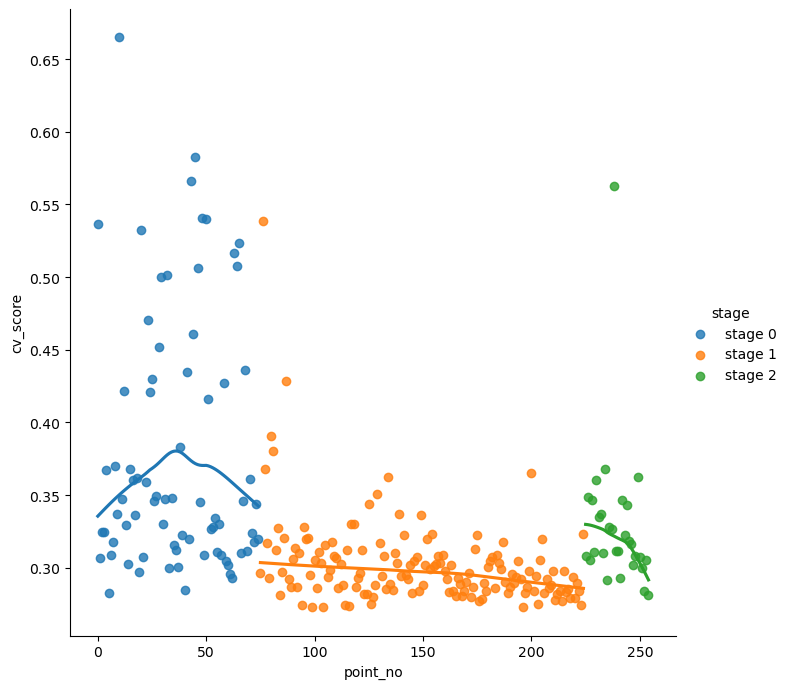

In [9]:
import seaborn as sbn
import matplotlib.pyplot as plt

df_final['point_no'] = np.arange(len(df_final))
sbn.lmplot(data = df_final, x = 'point_no', y = 'cv_score', hue = 'stage', lowess = True, height = 7, aspect = 1)

As we can see in stage 0 the performance of the points is rather random as we would expect when picking random points to evaluates. Once we enter stage 1 the performance immediately improves and shows a light trend towards better performing points as the stage progresses, indeed the worst performing points of stage 1 are almost all found in the first half of it while the density of good performing points improves over time. Again, stage 2 is very curious. Some rather poor performing points are evaluated at the beginning and only towards the end there is a succession of better performing points. As mentioned above this is probably due to the fact that once putting stage 0 and stage 1 points together the good performing points suddenly outweigh the outliers much more than they did in stage 1 (remember in stage 1 every kernel only sees 1/5 of the points found in stage 1 but 2/3 of points of stage 0). This incentivizes the algorithm to search some of the boundary (and hence poor performing) points as the certainty on their performance is still high while the subset of points with high expected performance has already been evaluated quite a lot (~ 5 times as many points around there suddenly). 

Finally we will visualize the individual values of the hyperparameters that are examined during the algorithm. 

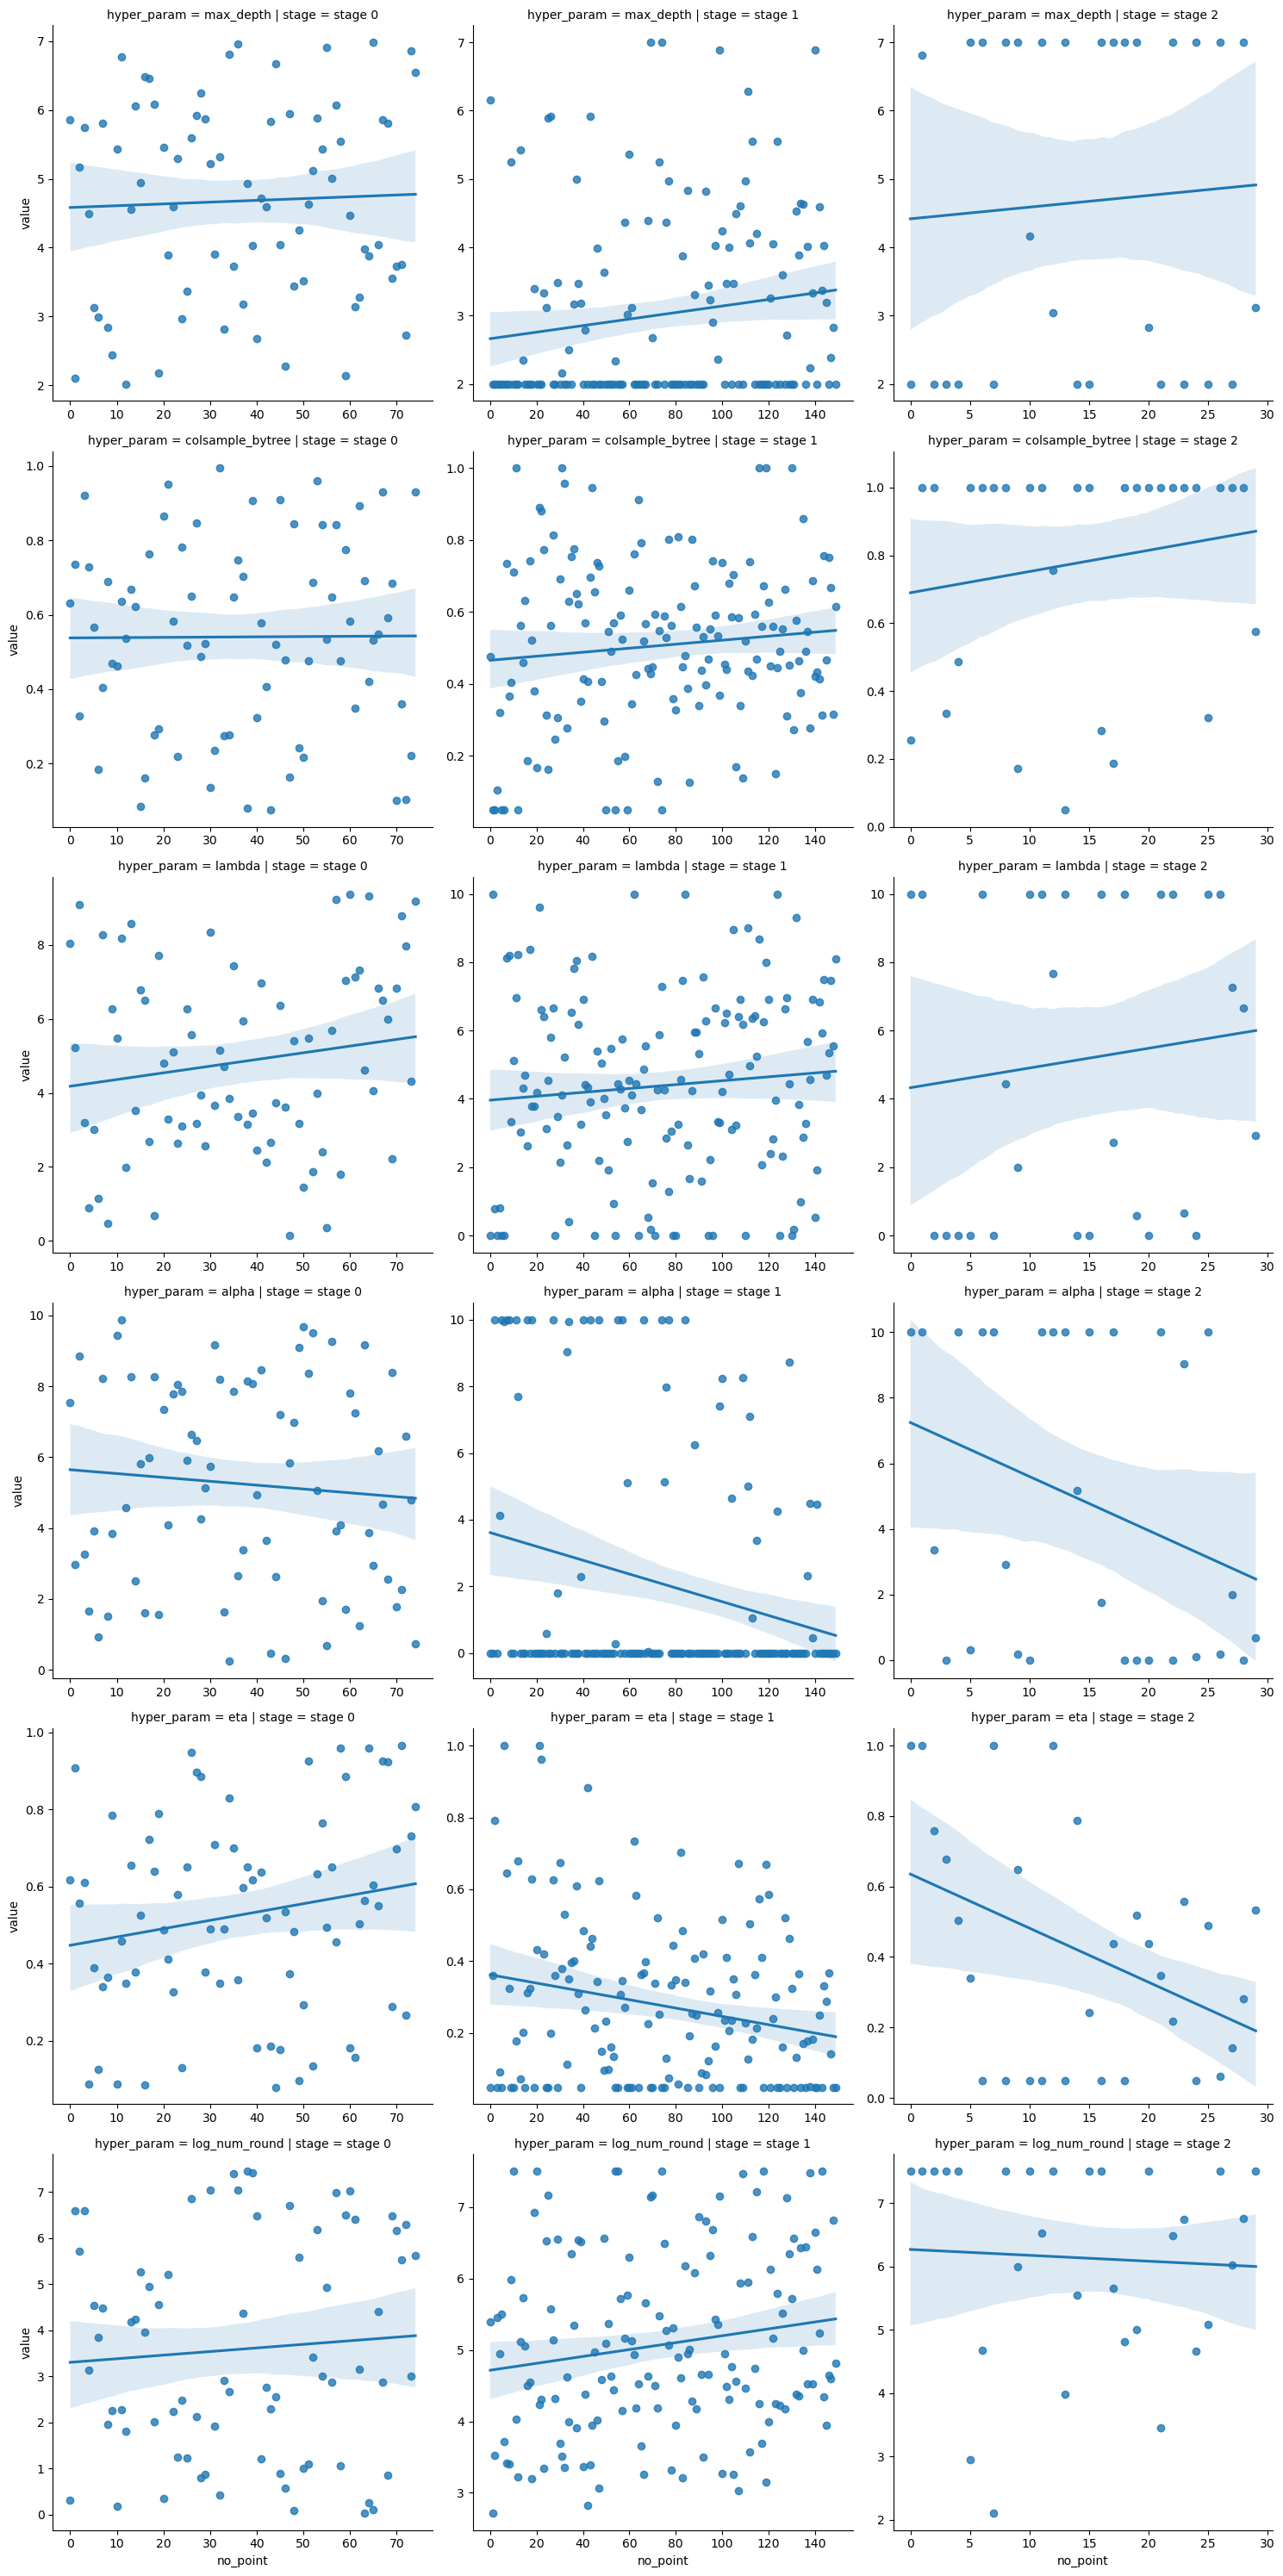

In [10]:
l_hyper_param = ['max_depth', 'colsample_bytree', 'lambda', 'alpha', 'eta', 'log_num_round']
l_stages = ['stage 0', 'stage 1', 'stage 2']
df_plot = pd.DataFrame( columns = ['no_point', 'value', 'hyper_param', 'stage'])

df_params = df_final.copy()

for st in l_stages:
    
    idx_start = 0 if st == 'stage 0' else 75 if st == 'stage 1' else 225
    idx_end = 75 if st == 'stage 0' else 225 if st == 'stage 1' else 255
    
    for h_p in l_hyper_param:
        
        new_part = pd.DataFrame({'no_point': np.arange(idx_end - idx_start).astype(float),
                                 'value': df_params.iloc[idx_start : idx_end,:][h_p],
                                 'hyper_param': h_p,
                                 'stage': st})
        df_plot = pd.concat((df_plot, new_part))


sbn.lmplot(data = df_plot, x = 'no_point', y = 'value', col = 'stage', row = 'hyper_param', fit_reg = True, facet_kws = {'sharex': False, 'sharey': False})

Some of the trends we identified earlier when looking at the best performing points are present within the above plots as well. Namely in stage 1 and stage 2 the chosen values of alpha decrease as the algorithm progresses while the learning rate decreases. Stage 1 also shows a light tendency to higher numbers of boosted rounds. A lot more potential trends do not seem to be present. Especially stage 2 apart from alpha and the learning rate lacks clear tendencies. This is due to mentioned attraction of the algorithm to boundary points that are often evaluated even when the region of best performing points has already been found. Due to the reason discussed earlier this becomes very obvious in stage 2. All hyperparameters are evaluated many times at their boundaries in stage 2. The boundary density of points seems often times to be even higher in stage 2 than it is in stage 1. 

# References

[1]: Peter I. Frazier: 'A Tutorial on Bayesian Optimization', arXiv:1807.02811 [stat.ML], 2018

[2]: C. Rassmussen and C. Williams: 'Gaussian Processes for Machine Learning', MIT Press, Camebridge, 2006

[3]: D. Jones, M. Schonlau and W. Welch: 'Efficient global optimization of expensive black-box functions', Journal of Global   
Optimization 13(4):455â€“492, 1998